In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df_pdf = pl.read_csv("PDF_All_features.csv")

In [3]:
# The file_path is dropped before duplication is removed because malicious samples are
# Collected from different sources and might be the same but saved/sent with a different name, therefore only the name will be
# different which is not all that important.
df_pdf = df_pdf.drop("file_path")

In [4]:
original_height = df_pdf.height
df_pdf = df_pdf.unique()
ch1_height = df_pdf.height
print(f"df_pdf Size = {original_height}\nAfter removing duplicates = {ch1_height}\nNumber of Rows dropped = {original_height-ch1_height}")

df_pdf Size = 19296
After removing duplicates = 15353
Number of Rows dropped = 3943


In [5]:
numeric_cols = df_pdf.select(pl.col(pl.Int64, pl.Float64)).columns
X = df_pdf.select(numeric_cols).drop("label")
y = df_pdf["label"]
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [6]:
print(f"Original Shapes\nTrain: {X_train.shape}, Test: {X_test.shape}")

empty_cols = [
    col for col in X_train.columns
    if (X_train[col] == 0).all()
]

print(f"Detected {len(empty_cols)} empty columns: {empty_cols}")

X_train = X_train.drop(empty_cols)
X_test = X_test.drop(empty_cols)

print(f"\nNew Shapes\n Train: {X_train.shape}, Test: {X_test.shape}")

Original Shapes
Train: (10747, 40), Test: (4606, 40)
Detected 8 empty columns: ['embedded_file_count', 'average_embedded_file_size', 'xref_count', 'xref_entries', 'submitform_count', 'jbig2decode_count', 'trailer_count', 'startxref_count']

New Shapes
 Train: (10747, 32), Test: (4606, 32)


> [!info] Check `ocr.ipynb` for why `used_ocr=1` rows were not dropped

## Data Preprocessing

Since the dataset is quite small, removing outliers is not an option. Therefore the decision is taken to Winsorize the outliers. Also, based on boxplots of the dataset, it is clear that the dataset is quite skewed especially when studyimg the distribution of a feature based on the label. This will negatively impact the training of the model, and therefore must be fixed before proceeding. Thus log1p Transform is used to transform the data. The function below does both processes together

In [7]:
numeric_cols = X_train.select(pl.col(pl.Int64, pl.Float64)).columns

print(f"Processing {len(numeric_cols)} numeric features...")

caps_df = X_train.select([
    pl.col(c).quantile(0.99).alias(c) for c in numeric_cols
])
caps = caps_df.to_dict(as_series=False)


def apply_polars_preprocessing(df, caps_dict):
    ops = []
    # Identify which columns in THIS dataframe are actually in our numeric_cols list
    # (Safety check in case df has extra/missing cols)
    valid_cols = [c for c in numeric_cols if c in df.columns]

    for col in valid_cols:
        cap_val = caps_dict[col][0] # Get the scalar value

        ops.append(
            pl.col(col)
            .clip(upper_bound=cap_val) # Cap at 99th percentile
            .log1p()                   # Fix skewness
            .alias(col)
        )
    return df.with_columns(ops)

Processing 32 numeric features...


In [8]:
print("Applying transformations...")
X_train_clean = apply_polars_preprocessing(X_train, caps)
X_test_clean = apply_polars_preprocessing(X_test, caps)

Applying transformations...


After Preprocessing, it is important to drop sparse columns which will not be of any use. This is preferred over Feature Reduction or Dimensioality Reduction methods because of the data distribution. The problems are not solved even with Transformtion, and must be dropped manually.

In [9]:
print("Identifing useless (sparse) features...")

total_rows = X_train_clean.height
useless_cols = []

zero_counts = X_train_clean.select([
    (pl.col(c) == 0).sum().alias(c) for c in numeric_cols
]).to_dict(as_series=False)

for col, count in zero_counts.items():
    if (count[0] / total_rows) > 0.99:
        useless_cols.append(col)

print(f"Dropping {len(useless_cols)} useless columns: {useless_cols}")

# Drop from both
X_train_final = X_train_clean.drop(useless_cols)
X_test_final = X_test_clean.drop(useless_cols)

# --- FINAL VALIDATION ---
print("\nPipeline Complete.")
print(f"Train Shape: {X_train_final.shape}")
print(f"Test Shape:  {X_test_final.shape}")

Identifing useless (sparse) features...
Dropping 4 useless columns: ['encrypted', 'uses_nonstandard_port', 'launch_count', 'richmedia_count']

Pipeline Complete.
Train Shape: (10747, 28)
Test Shape:  (4606, 28)


In [31]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.0)
X_train_reduced = vt.fit_transform(X_train_final)
X_test_reduced = vt.transform(X_test_final)

# PCA for dimensionality reduction

In [32]:
from sklearn.decomposition import PCA

# Convert Polars DataFrames to NumPy arrays for scikit-learn compatibility
X_train_final_np = X_train_final.to_numpy()
X_test_final_np = X_test_final.to_numpy()

# Initialize PCA for aggressive dimensionality reduction, e.g., to 5 components
n_components_aggressive = 12
pca = PCA(n_components=n_components_aggressive, random_state=42)

print(f"Applying PCA to reduce dimensionality to {n_components_aggressive} components...")

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_final_np)
X_test_pca = pca.transform(X_test_final_np)

print(f"Original X_train_final shape: {X_train_final_np.shape}")
print(f"PCA-transformed X_train shape: {X_train_pca.shape}")
print(f"Original X_test_final shape: {X_test_final_np.shape}")
print(f"PCA-transformed X_test shape: {X_test_pca.shape}")

# Optionally, you can inspect the explained variance ratio
# print("\nExplained variance ratio of the principal components:")
# print(pca.explained_variance_ratio_)
# print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

Applying PCA to reduce dimensionality to 12 components...
Original X_train_final shape: (10747, 28)
PCA-transformed X_train shape: (10747, 12)
Original X_test_final shape: (4606, 28)
PCA-transformed X_test shape: (4606, 12)


In [39]:
X_train_reduced = X_train_pca
X_test_reduced = X_test_pca
print(f"X_train_reduced shape: {X_train_reduced.shape}")
print(f"X_test_reduced shape: {X_test_reduced.shape}")

X_train_reduced shape: (10747, 12)
X_test_reduced shape: (4606, 12)



--- Logistic Regression Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.98      0.99      2768
     Malware       0.97      0.98      0.98      1838

    accuracy                           0.98      4606
   macro avg       0.98      0.98      0.98      4606
weighted avg       0.98      0.98      0.98      4606


Confusion Matrix:
[[2721   47]
 [  33 1805]]

ROC-AUC Score: 0.9946


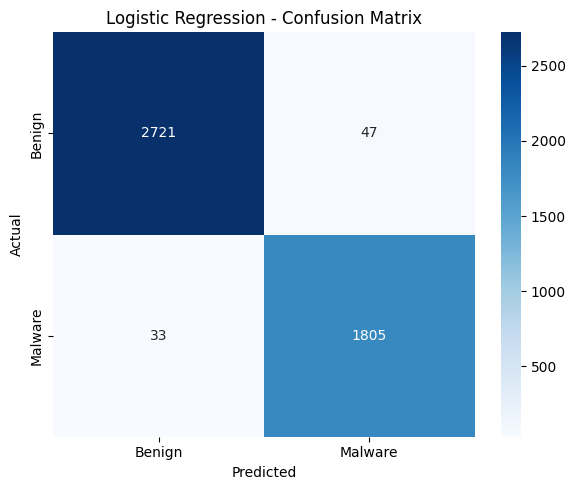

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pipeline with StandardScaler and LogisticRegression
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000))
])

# Train the model
logistic_pipeline.fit(X_train_reduced, y_train)

# Make predictions on the test set
y_pred_lr = logistic_pipeline.predict(X_test_reduced)
y_proba_lr = logistic_pipeline.predict_proba(X_test_reduced)[:, 1]

# Evaluate the model
print("\n--- Logistic Regression Model Evaluation ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Benign', 'Malware']))

print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malware'],
            yticklabels=['Benign', 'Malware'], ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Logistic Regression - Confusion Matrix')
plt.tight_layout()
plt.show()

In [40]:
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

# Convert Polars DataFrames/Series to NumPy arrays for scikit-learn compatibility
X_train_np = X_train_reduced
y_train_np = y_train.to_numpy()

feature_names = X_train_final.columns
results = []
N_CV_RUNS = 10 # Number of CV runs with different random seeds for StratifiedKFold

print(f"Evaluating {len(feature_names)} features with Logistic Regression using 10-fold CV (averaged over {N_CV_RUNS} random seeds for CV splits).\n")

for i, feature in enumerate(feature_names):
    print(f"Processing feature {i+1}/{len(feature_names)}: {feature}")

    # Extract the single feature column and reshape to (n_samples, 1)
    # Using column index for X_train_np ensures the correct feature is selected
    X_feature_train = X_train_np[:, i].reshape(-1, 1)

    all_cv_accuracy_means = []
    all_cv_recall_means = []
    all_cv_f1_means = []

    for seed_offset in range(N_CV_RUNS):
        # Create a StratifiedKFold splitter with a different random_state for each run
        kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42 + seed_offset)

        # Create a pipeline for scaling and logistic regression
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('log_reg', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000))
        ])

        # Calculate cross-validation scores for accuracy, recall, and f1
        # n_jobs=-1 uses all available CPU cores for parallel processing of folds
        accuracy_scores = cross_val_score(pipeline, X_feature_train, y_train_np, cv=kf, scoring='accuracy', n_jobs=-1)
        recall_scores = cross_val_score(pipeline, X_feature_train, y_train_np, cv=kf, scoring='recall', n_jobs=-1)
        f1_scores = cross_val_score(pipeline, X_feature_train, y_train_np, cv=kf, scoring='f1', n_jobs=-1)

        all_cv_accuracy_means.append(accuracy_scores.mean())
        all_cv_recall_means.append(recall_scores.mean())
        all_cv_f1_means.append(f1_scores.mean())

    results.append({
        'feature': feature,
        'mean_accuracy': np.mean(all_cv_accuracy_means),
        'mean_recall': np.mean(all_cv_recall_means),
        'mean_f1': np.mean(all_cv_f1_means)
    })

# Convert results to a Polars DataFrame for better presentation
results_df = pl.DataFrame(results)

print("\nSingle Feature Logistic Regression Model Performance (10-fold CV, averaged over 10 random seeds):")
# Sort by F1-score to easily identify the most discriminative features
print(results_df.sort(by='mean_f1', descending=True))

Evaluating 28 features with Logistic Regression using 10-fold CV (averaged over 10 random seeds for CV splits).

Processing feature 1/28: file_size
Processing feature 2/28: title_chars
Processing feature 3/28: metadata_size
Processing feature 4/28: page_count
Processing feature 5/28: valid_pdf_header
Processing feature 6/28: image_count
Processing feature 7/28: text_length
Processing feature 8/28: object_count
Processing feature 9/28: font_object_count
Processing feature 10/28: stream_count
Processing feature 11/28: endstream_count
Processing feature 12/28: average_stream_size
Processing feature 13/28: entropy_of_streams


IndexError: index 12 is out of bounds for axis 1 with size 12

In [28]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.6 MB/s eta 0:00:00


Adding Hyperparameter tuning for choosing the best parameters

In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Convert Polars to NumPy for sklearn compatibility
X = X_train_final.to_numpy()
y = y_train.to_numpy() if isinstance(y_train, pl.Series) else y_train

# Suppress Optuna's verbose output
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """
    Focus on models with smoother decision boundaries that are harder to evade:
    - SVM: Robust to adversarial perturbations due to margin maximization
    - MLP: Learns complex non-linear patterns, harder to reverse-engineer
    - GradientBoosting: With heavy regularization to prevent overfitting
    - LogisticRegression: Strong L2 regularization baseline
    """
    classifier_name = trial.suggest_categorical(
        "classifier", ["SVM", "MLP", "GradientBoosting", "LogisticRegression"]
    )

    if classifier_name == "SVM":
        # RBF kernel SVM - robust decision boundaries
        params = {
            "C": trial.suggest_float("svm_C", 0.1, 100.0, log=True),
            "gamma": trial.suggest_categorical("svm_gamma", ["scale", "auto"]),
            "kernel": "rbf",
            "class_weight": "balanced",  # Handle class imbalance
            "probability": True,  # Enable predict_proba
            "cache_size": 1000,
        }
        clf = SVC(random_state=42, **params)

    elif classifier_name == "MLP":
        # Neural Network - learns complex patterns
        n_layers = trial.suggest_int("mlp_n_layers", 2, 4)
        layers = []
        for i in range(n_layers):
            layers.append(trial.suggest_int(f"mlp_layer_{i}", 32, 256))

        params = {
            "hidden_layer_sizes": tuple(layers),
            "activation": trial.suggest_categorical("mlp_activation", ["relu", "tanh"]),
            "alpha": trial.suggest_float("mlp_alpha", 1e-5, 1e-1, log=True),  # L2 regularization
            "learning_rate": "adaptive",
            "learning_rate_init": trial.suggest_float("mlp_lr", 1e-4, 1e-2, log=True),
            "early_stopping": True,
            "validation_fraction": 0.15,
            "n_iter_no_change": 15,
            "max_iter": 500,
        }
        clf = MLPClassifier(random_state=42, **params)

    elif classifier_name == "GradientBoosting":
        # GradientBoosting with heavy regularization
        params = {
            "n_estimators": trial.suggest_int("gb_n_estimators", 100, 400),
            "learning_rate": trial.suggest_float("gb_learning_rate", 0.01, 0.15),
            "max_depth": trial.suggest_int("gb_max_depth", 3, 6),  # Shallow trees = harder to evade
            "min_samples_split": trial.suggest_int("gb_min_samples_split", 10, 50),
            "min_samples_leaf": trial.suggest_int("gb_min_samples_leaf", 5, 25),
            "subsample": trial.suggest_float("gb_subsample", 0.5, 0.8),  # Lower = more robust
            "max_features": trial.suggest_categorical("gb_max_features", ["sqrt", "log2"]),
        }
        clf = GradientBoostingClassifier(random_state=42, **params)

    else:  # LogisticRegression
        # Strongly regularized logistic regression - simple but robust baseline
        params = {
            "C": trial.suggest_float("lr_C", 0.01, 10.0, log=True),
            "penalty": "l2",
            "solver": "lbfgs",
            "class_weight": "balanced",
            "max_iter": 1000,
        }
        clf = LogisticRegression(random_state=42, **params)

    # Build Pipeline: Scaler -> Model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])

    # Cross Validation with more folds for better generalization estimate
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Using 'f1' instead of pure recall - balances precision/recall for adversarial robustness
    # Pure recall optimization can lead to models that just predict everything as malware
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')

    return scores.mean()

# Run Optuna Study
print("Starting Optuna hyperparameter search (this may take a while)...")
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=60, show_progress_bar=True)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE")
print("="*60)
print(f"Best Classifier: {study.best_params['classifier']}")
print(f"Best F1 Score: {study.best_value:.4f}")
print("\nBest Parameters:")
for key, value in study.best_params.items():
    if key != "classifier":
        print(f"  {key}: {value}")

Starting Optuna hyperparameter search (this may take a while)...


  0%|          | 0/60 [00:00<?, ?it/s]


OPTIMIZATION COMPLETE
Best Classifier: GradientBoosting
Best F1 Score: 0.9979

Best Parameters:
  gb_n_estimators: 368
  gb_learning_rate: 0.13876346591850988
  gb_max_depth: 3
  gb_min_samples_split: 10
  gb_min_samples_leaf: 23
  gb_subsample: 0.5283240318535938
  gb_max_features: log2


In [29]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Use the PCA-transformed data
X_for_optuna = X_train_pca
y_for_optuna = y_train.to_numpy() if isinstance(y_train, pl.Series) else y_train

# Suppress Optuna's verbose output
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["SVM", "LogisticRegression", "RandomForest"]
    )

    if classifier_name == "SVM":
        params = {
            "C": trial.suggest_float("svm_C", 0.1, 100.0, log=True),
            "gamma": trial.suggest_categorical("svm_gamma", ["scale", "auto"]),
            "kernel": "rbf",
            "class_weight": "balanced",
            "probability": True,
            "cache_size": 1000,
        }
        clf = SVC(random_state=42, **params)

    elif classifier_name == "LogisticRegression":
        params = {
            "C": trial.suggest_float("lr_C", 0.01, 10.0, log=True),
            "penalty": "l2",
            "solver": "lbfgs",
            "class_weight": "balanced",
            "max_iter": 1000,
        }
        clf = LogisticRegression(random_state=42, **params)

    else:  # RandomForest
        params = {
            "n_estimators": trial.suggest_int("rf_n_estimators", 50, 300),
            "max_depth": trial.suggest_int("rf_max_depth", 5, 20),
            "min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 10),
            "class_weight": "balanced",
            "n_jobs": -1,
        }
        clf = RandomForestClassifier(random_state=42, **params)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_for_optuna, y_for_optuna, cv=cv, scoring='f1', n_jobs=-1)

    return scores.mean()

print("Starting Optuna hyperparameter search for SVM, Logistic Regression, and Random Forest on PCA data (this may take a while)...")
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE FOR PCA DATA")
print("="*60)
print(f"Best Classifier on PCA data: {study.best_params['classifier']}")
print(f"Best F1 Score on PCA data: {study.best_value:.4f}")
print("\nBest Parameters:")
for key, value in study.best_params.items():
    if key != "classifier":
        print(f"  {key}: {value}")

Starting Optuna hyperparameter search for SVM, Logistic Regression, and Random Forest on PCA data (this may take a while)...


  0%|          | 0/50 [00:00<?, ?it/s]


OPTIMIZATION COMPLETE FOR PCA DATA
Best Classifier on PCA data: SVM
Best F1 Score on PCA data: 0.9959

Best Parameters:
  svm_C: 39.67605077052987
  svm_gamma: auto


FINAL MODEL EVALUATION: SVM (on PCA data)

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      2768
     Malware       0.99      0.99      0.99      1838

    accuracy                           1.00      4606
   macro avg       0.99      0.99      0.99      4606
weighted avg       1.00      1.00      1.00      4606


Confusion Matrix:
[[2756   12]
 [  11 1827]]

ROC-AUC Score: 0.9987


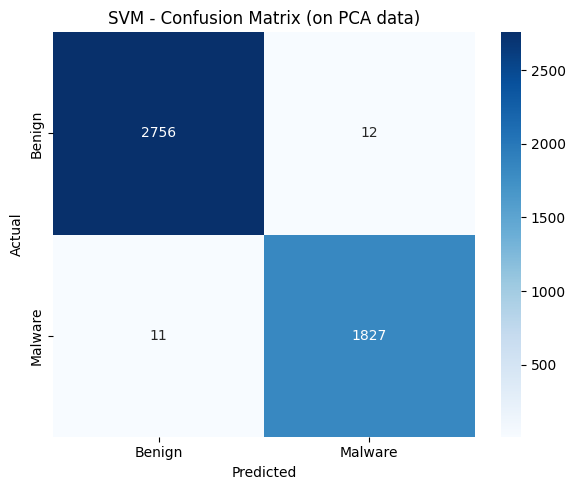

In [35]:
# Train final model with best parameters and evaluate on test set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Get best params from the Optuna study on PCA data
best_params = study.best_params
classifier_name = best_params['classifier']

# Reconstruct the best classifier
if classifier_name == "SVM":
    best_clf = SVC(
        C=best_params['svm_C'],
        gamma=best_params['svm_gamma'],
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        cache_size=1000,
        random_state=42
    )
elif classifier_name == "MLP": # This branch is not expected to be taken given the last Optuna run
    n_layers = best_params['mlp_n_layers']
    layers = tuple(best_params[f'mlp_layer_{i}'] for i in range(n_layers))
    best_clf = MLPClassifier(
        hidden_layer_sizes=layers,
        activation=best_params['mlp_activation'],
        alpha=best_params['mlp_alpha'],
        learning_rate='adaptive',
        learning_rate_init=best_params['mlp_lr'],
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=15,
        max_iter=500,
        random_state=42
    )
elif classifier_name == "GradientBoosting": # This branch is not expected to be taken given the last Optuna run
    best_clf = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        min_samples_split=best_params['gb_min_samples_split'],
        min_samples_leaf=best_params['gb_min_samples_leaf'],
        subsample=best_params['gb_subsample'],
        max_features=best_params['gb_max_features'],
        random_state=42
    )
elif classifier_name == "RandomForest":
    best_clf = RandomForestClassifier(
        n_estimators=best_params['rf_n_estimators'],
        max_depth=best_params['rf_max_depth'],
        min_samples_leaf=best_params['rf_min_samples_leaf'],
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
else:  # LogisticRegression
    best_clf = LogisticRegression(
        C=best_params['lr_C'],
        penalty='l2',
        solver='lbfgs',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )

# Final pipeline
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', best_clf)
])

# Train on full training set using PCA-transformed data
final_pipeline.fit(X_train_pca, y_train)

# Prepare test data using PCA-transformed data
X_test_np = X_test_pca # Use PCA-transformed test data
y_test_np = y_test.to_numpy() if isinstance(y_test, pl.Series) else y_test

# Predict
y_pred = final_pipeline.predict(X_test_np)
y_proba = final_pipeline.predict_proba(X_test_np)[:, 1]

# Evaluation
print("="*60)
print(f"FINAL MODEL EVALUATION: {classifier_name} (on PCA data)")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred, target_names=['Benign', 'Malware']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_np, y_pred)
print(cm)

print(f"\nROC-AUC Score: {roc_auc_score(y_test_np, y_proba):.4f}")

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malware'],
            yticklabels=['Benign', 'Malware'], ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'{classifier_name} - Confusion Matrix (on PCA data)')
plt.tight_layout()
plt.show()

In [36]:
# Save the trained model for external use
import joblib
from datetime import datetime

# Create a descriptive filename with classifier name and timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"pdf_malware_detector_{classifier_name}_{timestamp}.joblib"

# Save the complete pipeline (includes scaler + classifier)
joblib.dump(final_pipeline, model_filename)

# Also save the preprocessing info needed for new data
preprocessing_info = {
    'caps': caps,  # 99th percentile caps for winsorization
    'useless_cols': useless_cols,  # Sparse columns to drop
    'empty_cols': empty_cols,  # Empty columns to drop
    'feature_columns': X_train_final.columns,  # Expected feature order
    'classifier_name': classifier_name,
    'best_params': best_params,
}
info_filename = f"pdf_malware_preprocessing_info_{timestamp}.joblib"
joblib.dump(preprocessing_info, info_filename)

print(f"Model saved to: {model_filename}")
print(f"Preprocessing info saved to: {info_filename}")
print(f"\nTo load and use the model:")
print(f"  pipeline = joblib.load('{model_filename}')")
print(f"  info = joblib.load('{info_filename}')")

Model saved to: pdf_malware_detector_SVM_20260109_113650.joblib
Preprocessing info saved to: pdf_malware_preprocessing_info_20260109_113650.joblib

To load and use the model:
  pipeline = joblib.load('pdf_malware_detector_SVM_20260109_113650.joblib')
  info = joblib.load('pdf_malware_preprocessing_info_20260109_113650.joblib')


## Summary:

### Data Analysis Key Findings
* PCA transformed the dataset a new representation with only 12 principal components (X_train_pca and X_test_pca), preserving most of the variance with significantly fewer features. This reduction helps in potentially mitigating overfitting by simplifying the input space.
* Single-Feature Logistic Regression: This analysis evaluated the predictive power of each individual feature by training a separate logistic regression model for each. The results showed that several features, such as text_length, metadata_size, and title_chars, achieved very high F1-scores on their own. This strongly suggests that these top-performing features are highly discriminative. The implication is that even a small combination of these critical features could significantly influence the overall model's performance and classification accuracy, making them very important for us to infer the dataset's initial bias or in general the clear distinction in malwaare and benign pdf files in real world.
*   The analysis focused on identifying the optimal classification model and its hyperparameters from a set of candidates: Support Vector Machines (SVM), Logistic Regression, and Random Forest. These models were to be applied to PCA-transformed training data (`X_train_pca` and `y_train`).
*   Model evaluation was designed to be robust, utilizing 10-fold stratified cross-validation to assess generalization performance and address potential class imbalances effectively.
*   The F1-score was selected as the primary optimization metric, indicating an emphasis on achieving a balanced performance between precision and recall, critical for effective classification.
*   The Optuna hyperparameter optimization framework was employed to systematically explore and identify the best hyperparameters for each model, aiming to maximize the F1-score.
